# Test the AutoEncoder class on a small example dataset

This little example shows how to initialize and train the AutoEncoder on a tiny dataset.

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch

import local_env
from VideoAnalysisUtils import autoencoder as ae

#### Load example images

This is 5 preprocessed - cropped and resized - images.

In [3]:
example_images = np.load('../data/example_images.npy')
print(example_images.shape) # 5 example greyscale, resized and cropped images

(5, 120, 112)


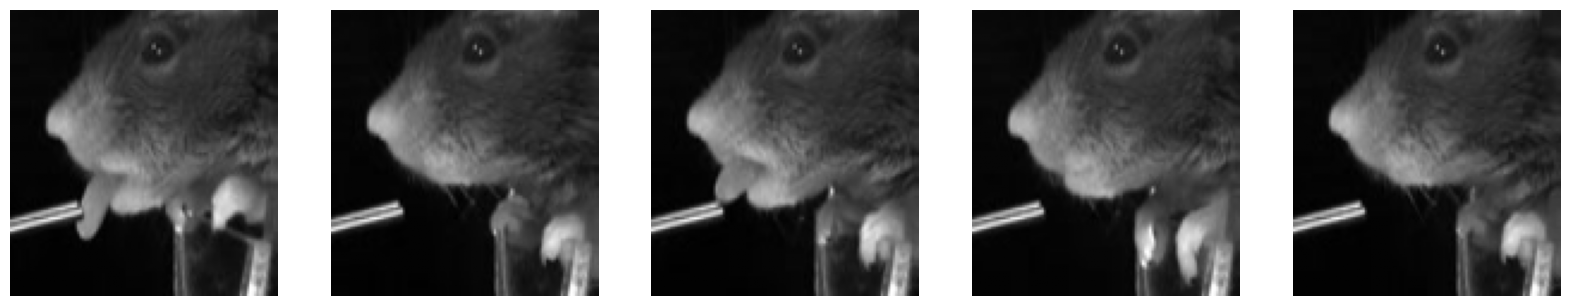

In [5]:
plt.subplots(1,5, figsize=(20, 4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(example_images[i,], cmap='gray')
    plt.axis('off')

#### Set up the AutoEncoder

The below configs correspond to the final model architecture.

In [6]:
configs = {
    'num_blocks': 2,
    'in_channels_0': 1,
    'out_channels_0': 16,
    'in_channels_1': 16,
    'out_channels_1': 32,
    'kernel_preconv': 3,
    'stride_preconv': 1,
    'pool_size_preconv_0': 2,
    'pool_size_preconv_1': 4,
    'use_batch_norm_preconv': False,
    'kernel_residual': 3,
    'stride_residual': 1,
    'use_batch_norm_residual': False,
    'pool_size_residual_0': None,
    'pool_size_residual_1': 4,
    'n_layers_residual': 3,
    'out_conv': 288,
    'out_linear': 128,
    'embed_size': 16,
    'use_batch_norm_linear': False,
    'image_height': 120,
    'image_width': 112
}

In [8]:
AE = ae.AutoEncoder(configs)

#### Baby training loop on the 5 images

In [9]:
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)

loss_fn = torch.nn.MSELoss()

n_epochs = 1000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    x_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
    loss = loss_fn(x_hat.squeeze(), torch.tensor(example_images).float())
    loss.backward()
    optimizer.step()
    if epoch%100 == 99: print(epoch, loss.item())

99 0.005703524686396122
199 0.0046951016411185265
299 0.004596156999468803
399 0.0035147739108651876
499 0.0021821765694767237
599 0.001886052661575377
699 0.001782635459676385
799 0.0016095953760668635
899 0.0013326117768883705
999 0.0009744413546286523


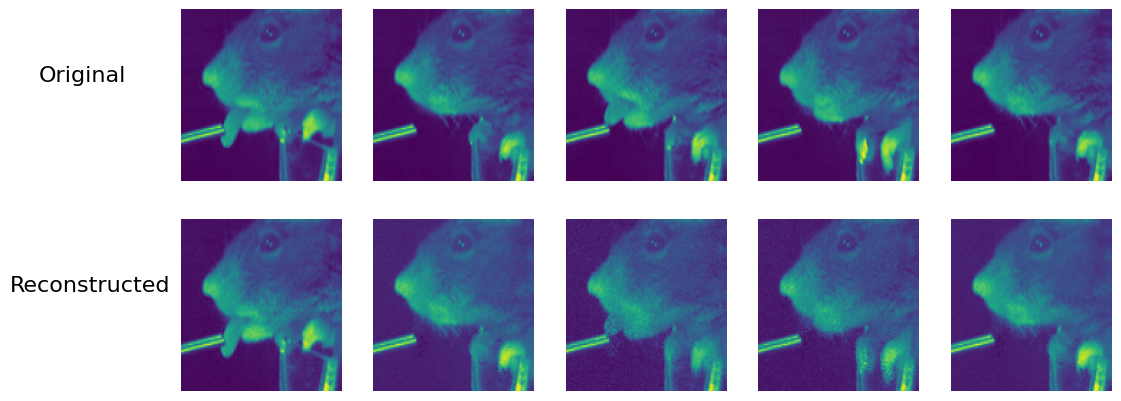

In [22]:
with torch.no_grad():
    img_hat, z = AE.forward(torch.tensor(example_images).float().view(5,1,1,120,112))
plt.subplots(2,5,figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(example_images[i])
    plt.axis('off')
    if i == 0: plt.text(-100, 50, 'Original', fontsize=16)
    plt.subplot(2,5,i+6)
    plt.imshow(img_hat.squeeze().detach().numpy()[i])
    plt.axis('off')
    if i == 0: plt.text(-120, 50, 'Reconstructed',fontsize=16)

#### Training loop using webdataset dataloader

The specific implementation of the dataloader will depend on how the images/videos are formatted. For the full training we stored the videos stored as split images which gave us the flexibility and reading speed necessary to train on the full dataset (especially for the end-to-end network). Here, the images are read from a .tar file that is just a collection of images belonging to a single sessin.

In [26]:
from VideoAnalysisUtils import end_to_end as e2e
import webdataset as wds
from torch.utils.data import DataLoader
import time

In [24]:
custom_transform = e2e.CustomCropResize(target_shape=(120, 112, 1), crop_info={'h_coord': 26})

In [ ]:
path_to_tar_file = "/home/kurgyis/Research/MapVideoAnalysis/data/raw_frames/SC065_20210506_frames.tar"

dataset = wds.WebDataset(
    path_to_tar_file,
).select(lambda sample: "jpg" in sample) \
  .shuffle(1024).decode('pil') \
  .to_tuple("jpg") \
  .map(lambda x: custom_transform(x[0]))

dataloader = DataLoader(dataset, batch_size=256, num_workers=1)


start_time = time.time()
for i, batch in enumerate(dataloader):
    if i >= 100:
        break
end_time = time.time()
images_per_second = 256 / ((end_time - start_time) / 100)
print(f"Images per second: {images_per_second:.2f}")
# There are about 700k images in this session
estimated_total_time = (700000 / images_per_second) / 60  # Minutes
print(f"Estimated time to load 700k images: {estimated_total_time:.2f} minutes")

Images per second: 2649.41
Estimated time to load 700k images: 4.40 minutes


#### Mini training loop on the full dataset

We will do only a few batches here, as the full training takes a while.

In [40]:
AE = ae.AutoEncoder(configs)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)
batch_size = 256
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=1)
loss_fn = torch.nn.MSELoss()

n_epochs = 1
n_batches = 250

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AE.to(device)

for epoch in range(n_epochs):
    for i_batch, sample_batched in enumerate(dataloader):
        if sample_batched.size()[0] != batch_size:
            continue
        optimizer.zero_grad()
        x_hat, z = AE.forward(sample_batched.to(device).view(batch_size,1,1,120,112))
        loss = loss_fn(x_hat.squeeze(), sample_batched.to(device).float())
        loss.backward()
        optimizer.step()
        if i_batch%10 == 9: print(epoch, i_batch, loss.item())
        if i_batch >= n_batches - 1:
            break

/home/kurgyis/Research/MapVideoAnalysis/local_venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([256, 1, 120, 112])) that is different to the input size (torch.Size([256, 120, 112])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 9 0.08653473854064941
0 19 0.0761709064245224
0 29 0.0575173944234848
0 39 0.04084880277514458
0 49 0.026240475475788116
0 59 0.016316497698426247
0 69 0.010691900737583637
0 79 0.00698285223916173
0 89 0.005664781201630831
0 99 0.00480789365246892
0 109 0.0038487985730171204
0 119 0.00530668580904603
0 129 0.0030345029663294554
0 139 0.004501887131482363
0 149 0.004855917766690254
0 159 0.0035482929088175297
0 169 0.0040017664432525635
0 179 0.0031741089187562466
0 189 0.0025927855167537928
0 199 0.0036987627390772104
0 209 0.003528330475091934
0 219 0.004727495368570089
0 229 0.0031970113050192595
0 239 0.004079103469848633
0 249 0.00366410706192255


#### Extract the latents

We do not expect to see anything beyond some vague shapes and mostly noise, as the model has not been trained for long enough.

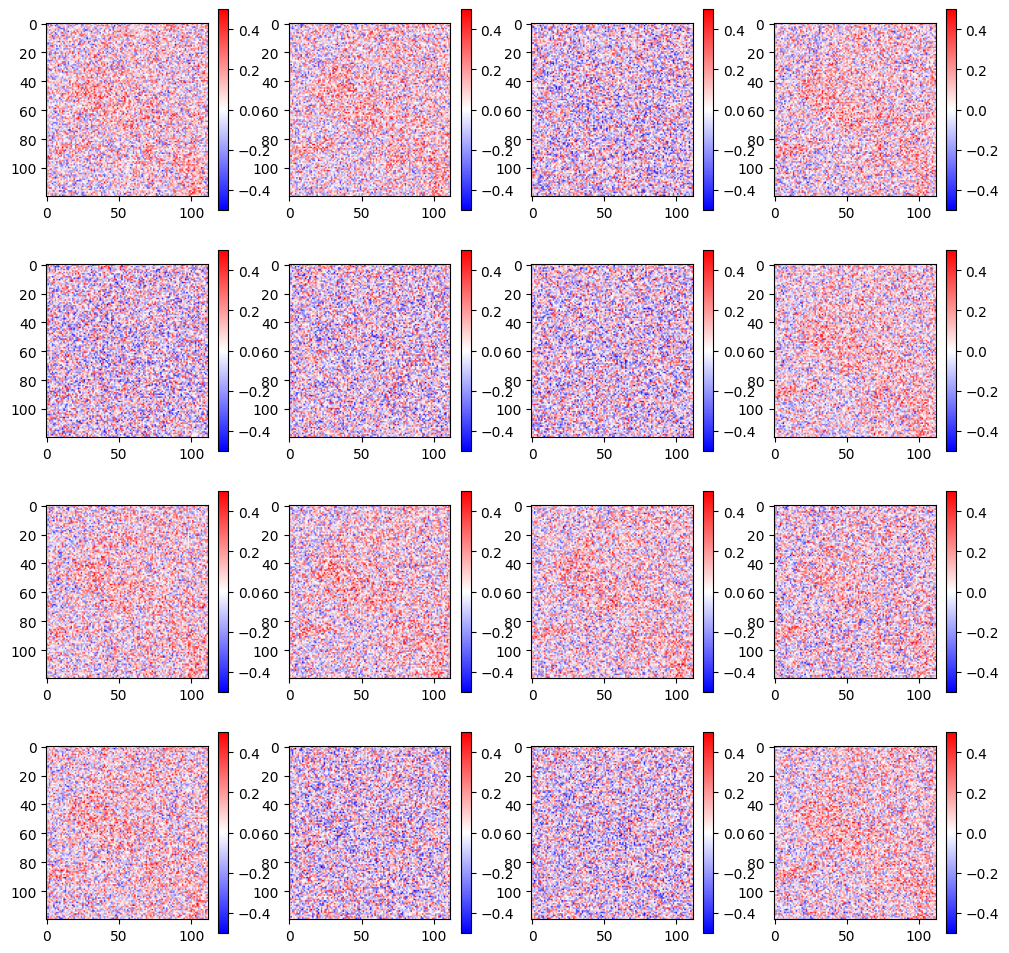

In [41]:
latents = []
for i in range(16):
    input_z = torch.zeros(1,1,16).to(device)
    input_z[0,0,i] = 1
    latent = AE.decoder(input_z).squeeze().cpu().detach().numpy()
    latents.append(latent)

plt.subplots(4,4,figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(latents[i], cmap = 'bwr', vmin = -0.5, vmax = 0.5)
    plt.colorbar()